# Data Exploration

Number of car image: 8792
Number of non-car image: 8968
Image size: (64, 64, 3)
Data type: float32


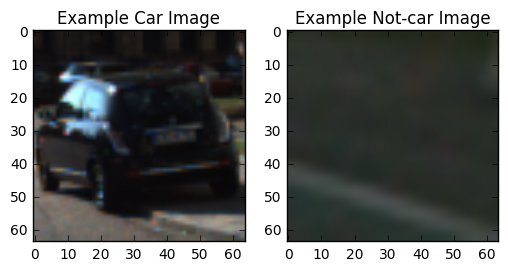

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Number of car image:', data_info["n_cars"])
print('Number of non-car image:', data_info["n_notcars"])
print('Image size:', data_info["image_shape"])
print('Data type:', data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind], format='PNG')
notcar_image = mpimg.imread(notcars[notcar_ind], format='PNG')

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Save images
mpimg.imsave('output_images/car_image.png', car_image)
mpimg.imsave('output_images/notcar_image.png', notcar_image)

# Histograms of Color

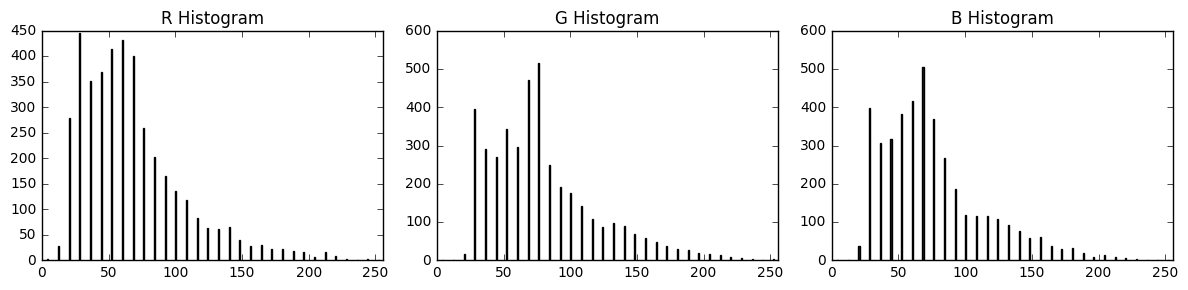

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(car_image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    fig.savefig('output_images/color_hist.png')
else:
    print('Your function is returning None for at least one variable...')

# Spatial Binning of Color

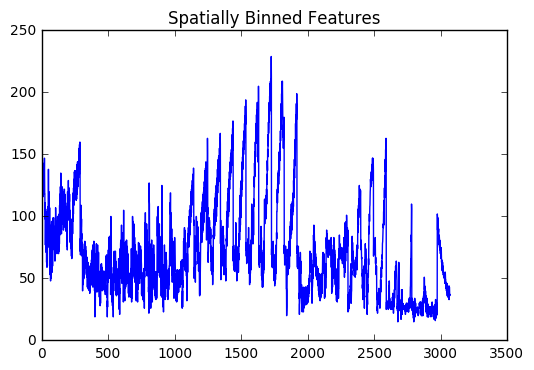

In [3]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(car_image, size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.savefig('output_images/bin_spatial.png')

# HOG features

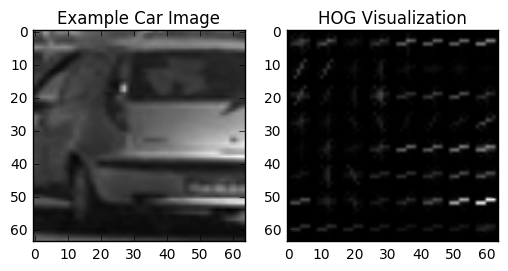

In [4]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

# Gray car image
gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# save images
mpimg.imsave('output_images/car_gray.png', gray)
mpimg.imsave('output_images/car_gray_hog.png', hog_image)

# Combine and Normalize Features

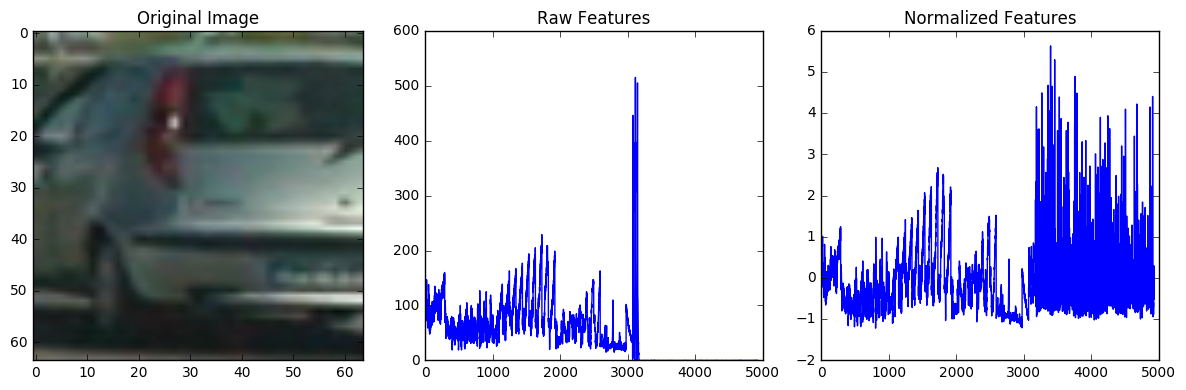

In [5]:
from sklearn.preprocessing import StandardScaler

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feature=True, hist_feature=True, hog_feature=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        combined_features = []
        # Read in each one by one
        image = mpimg.imread(file, format='PNG')
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)
        
        if spatial_feature:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            combined_features.append(spatial_features)
        if hist_feature:
            # Apply color_hist() also with a color space option now
            _,_,_,_,hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            combined_features.append(hist_features)
        if hog_feature:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            combined_features.append(hog_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(combined_features))
    # Return list of feature vectors
    return features

car_features = extract_features(cars)
notcar_features = extract_features(notcars)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(car_image)
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    fig.savefig('output_images/extract_feature.png')
else: 
    print('Your function only returns empty feature vectors...')

# Tweak parameters

In [13]:
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# Reduce the sample size because HOG features are slow to compute
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_on = True
spatial = 32
hist_on = True
histbin = 32

t=time.time()
car_features = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feature=spatial_on, hist_feature=hist_on)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=(spatial, spatial),
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feature=spatial_on, hist_feature=hist_on)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.97 Seconds to extract features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 27468
0.67 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  1.]
0.00259 Seconds to predict 10 labels with SVC
